# **HW4: Machine Learning Based Investment Strategy For NBA Players Memorabilia**

## **BAX 357 - Predictive Analytics**

Written by: Dr. Mark Tsechansky, Ethan Wong

Special Thanks: Juwon Lee, Jacob Foster

Student Names and Group Number: *Group 16: Ethan Davenport and Hasan Arif*

Participating in Competition: *Yes*

* For those participating in the competition, upon completing this HW assignment, please see the *OPTIONAL* section for the competition deliverables and guidelines.

* Failing to turn in this assignment by the due date will result in your group being REQUIRED to participate in the competition.

## **For this assignment, you will use real data on past basketball players and machine learning techniques to make informed memorabilia investment decisions! To begin, please import the following libraries and read in the dataframe below.**

Note: If you are using Google Colab, you must upload the NBA Data CSV from Canvas by doing the following:

* On the left-side bar, click the folder icon.
* Click the 'Upload to session storage' button.
* Upload the NBA Data CSV file; it will appear below the 'sample_data' folder.

**Unfortunately, this process must be done every time the runtime is disconnected - just a quirk with Google Colab.**

If you are using Jupyter notebook, just make sure the NBA Data CSV file is in the same folder location as this .ipynb file.

In [54]:
# Import Libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector as SFS, RFE # wrapper method functions
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Reset Plot Settings
plt.rcdefaults()

In [57]:
NBA_Data = pd.read_csv('NBA_Data.csv',index_col=0)

## **About the data:**

You are provided with data on past players that includes 27 different predictors/attributes on each player. The complete list is as follows:

Field | Description
------|------------
games|games played
minutes|minutes played
pts|points
offReb|offensive rebounds
defReb|defensive rebounds
reb|rebounds
asts|assists
stl|steals* (see below)
blk|blocks* (see below)
turnover|turnovers* (see below)
pf|Personal Fouls
fga|field goals attempted
fgm|field goals made
fta|free throws attempted
ftm|free throws made
tpa|three pointers attempted* (see below)
tpm|three pointers made* (see below)
totalSeasons|Total number of seasons played. This value is calculated as follows: "lastSeason - firstSeason + 1"
firstSeason|First season played. The year corresponds to the first year of the season (i.e. a value of 2000 represents the 2000-2001 season).
lastSeason|Last season played. The year corresponds to the first year of the season (i.e. a value of 2000 represents the 2000-2001 season). Note that 2004 (2004-2005 season) is the last year for which there is data.
careerEnded|Boolean field for if the player's career has ended (1 if career has ended, 0 otherwise). This field was calculated as follows: if the "lastSeason" field is earlier than 2004, the value is 1, otherwise 0. Note that this calculation naively assumes that no players retired at the end of the 2004  season.
yrsRetired2004|The number of seasons that a player has been retired as of the 2004-2005 season.
class|A Boolean field showing whether or not a player was inducted to the Basketball Hall of Fame (HoF) as a player. This field has value 1 if the player has been inducted, and 0 otherwise.
league| N = National Basketball Association (NBA); A = American Basketball Association (ABA)
position|C = Center; F = Forward; G = Guard

Important Notes:

* The NBA did not have three point shots until 1979.
* Steals, Blocks and Turnovers were not recorded in the NBA until 1973.

Each row corresponds to a player and contains the player's attributes above.

The first 5 rows of the dataframe are shown below:

In [ ]:
NBA_Data.head()

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,firstSeason,lastSeason,careerEnded,yrsRetired2004,class,league_A,league_N,Position_C,Position_F,Position_G
0,408.0,9825.0,5232.0,476.0,824.0,1300.0,866.0,265.0,175.0,700.0,...,1982.0,1990.0,1.0,14.0,False,0,1,0,0,1
1,51.0,0.0,587.0,0.0,0.0,0.0,158.0,0.0,0.0,0.0,...,1949.0,1949.0,1.0,55.0,False,0,1,0,0,1
2,265.0,0.0,1712.0,0.0,0.0,72.0,311.0,0.0,0.0,0.0,...,1946.0,1950.0,1.0,54.0,False,0,1,0,0,1
3,133.0,2587.0,992.0,55.0,198.0,253.0,291.0,123.0,14.0,207.0,...,2003.0,2004.0,0.0,0.0,False,0,1,0,0,1
4,8.0,28.0,7.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,...,2004.0,2004.0,0.0,0.0,False,0,1,0,0,1


**Your task is to use this historical dataset to build a classification model predicting whether or not a given player will be inducted into the NBA Hall of Fame (and the probability thereof). Once you build your model, you will then apply it to select players to invest in.**

The goal of this assignment is to develop hands-on experience in developing and evaluating different machine learning models to inform interventions (in this case, investment decisions) and to maximize profitability (**wherein each time you correctly predict that a player will be inducted into the hall of fame, you turn a profit, and every other player captured is considered a loss**). This will be explained in greater detail in Part III of the assignment.

The data set includes a target variable (i.e., the class) which indicates whether or not the player has been inducted to the hall of fame. The target variable is binary and has value 1 if the player has been inducted or 0 otherwise.

Important Notes:

* We assume that a player who has not been inducted 45.4 years after retirement, will not be inducted.
* The data includes the actual target variable value for each player. This information is available for this assignment in order to allow you to evaluate the efficacy of investment decisions and to compare amongst investments selected by different models to identify the best model to use in the future. However, in actual deployment, we would not have access to this target variable.

## **Part I: Building, Evaluating and Comparing Different Machine Learning Models  (20 Points)**

**1.1: For the purposes of this assignment, please create and fit a [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html), and [KNeighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to the data. Compare the results of your models using 10-Fold Cross Validation and display the results here for each model. Feel free to play with the parameters for each model to try and generate better results while keeping in mind best practices to avoid overfitting. (5 Points)**

Your goal is to optimize for model accuracy and area under the ROC (use [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)); do not worry about profitability at this stage.  

Additionally, make sure to split your data into a train and test dataset with the [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method. Consider the training data as historical data that you were provided with to develop an investment strategy. The test set includes players, the memorabilia of which you are considering to invest in.

**NOTE: When training these models AND splitting the data, you MUST use `random_state=3`. Additionally, please set `test_size = 0.33`. Failure to do so will result in no points being awarded for this question.**

In [3]:
def report_score(mymodel, X, y, mycv=10):
# To use this function, all we need to do is feed it our model of interest, X, y, and the number of folds for cross-validation.

    # Calculate and print the cross-validation accuracy
    cross_val_accuracy = round(cross_val_score(mymodel, X, y, cv = mycv).mean()*100,2)
    print(f"{mycv}-Fold Cross-Validation Classification Accuracy: {cross_val_accuracy:.2f} %")

    # Calculate and print the cross-validation ROC AUC
    cross_val_accuracy_roc_auc = round(cross_val_score(mymodel, X, y, cv =  mycv, scoring = 'roc_auc').mean()*100,2)
    print(f"{mycv}-Fold Cross-Validation ROC AUC: {cross_val_accuracy_roc_auc:.2f} %")

In [4]:
X = NBA_Data.drop(columns='class')
y = NBA_Data['class']

X = np.ascontiguousarray(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 3)

decision_tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state = 3).fit(X_train,y_train)
bagging = BaggingClassifier(random_state = 3).fit(X_train,y_train)
random_forest = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_features = 6).fit(X_train,y_train)
naive_bayes = MultinomialNB().fit(X_train,y_train)
kneighbors = KNeighborsClassifier(n_neighbors=5).fit(X_train,y_train)

models = ['decision_tree', 'bagging', 'random_forest', 'naive_bayes', 'kneighbors']
for model in models:
    print(model.replace("_", " ").title())
    report_score(globals()[model], X_train, y_train)

Decision Tree
10-Fold Cross-Validation Classification Accuracy: 97.29 %
10-Fold Cross-Validation ROC AUC: 91.69 %
Bagging
10-Fold Cross-Validation Classification Accuracy: 96.37 %
10-Fold Cross-Validation ROC AUC: 95.53 %
Random Forest
10-Fold Cross-Validation Classification Accuracy: 98.49 %
10-Fold Cross-Validation ROC AUC: 97.84 %
Naive Bayes
10-Fold Cross-Validation Classification Accuracy: 88.25 %
10-Fold Cross-Validation ROC AUC: 92.15 %
Kneighbors
10-Fold Cross-Validation Classification Accuracy: 97.28 %
10-Fold Cross-Validation ROC AUC: 88.65 %


**1.2: Using classification accuracy rate as the evaluation measure, which model best predicts whether or not a player will be inducted? (5 points)**

Based on classification accuracy, the random forest model best predicts whether or not a player will be inducted with a classification accuracy of 98.49%.

**1.3: Using the area under the ROC, which model yields the largest area under the ROC? (5 points)**

The random forest model also yields the greatest ROC AUC with 97.84%.

**1.4: Given your goal is to identify and invest in a set of players likely to be inducted to the Hall of Fame, which of the two measures above (classification accuracy rate or ROC area) is more appropriate for selecting the model to inform your investments? Explain your answer. (5 Points)**

Note that while classification accuracy rate and ROC area may often agree, in some cases the classification accuracy of two models may be comparable, while the ROC area of one may be larger than the other.

ROC areas is more appropriate to use for selecting a model to inform our investments because it accounts for the tradeoff between precision and recall, rather than just the percentage of correct predictions. This is important because there are profitability risks and rewards associated with the model's predictions and our investment decisions in this scenario.

## **Part II: Analysis and Model Improvement (40 Points)**

**2.1: Using a [correlation matrix](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) on the dataframe, list the three best predictors of a player’s future induction to the hall of fame (in other words, the three best predictors of the column 'class'). Explain why correlation is a valid ranking measure in this scenario.**

**Additionally, please explore further measures for evaluating the significance of features using the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) function, specificially focusing on "Mutual information" and "Chi-square." Is there a consensus among the correlation matrix, mutual information, and chi-square regarding the top three features? (10 points)**

To help you get started, we have provided some psuedo-code for you below.

In [ ]:
X = NBA_Data.drop(columns='class')
y = NBA_Data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 3)

In [5]:
# Correlation Matrix:

corr_matrix = NBA_Data.corr(method = 'pearson')
correlations_class = corr_matrix['class'].sort_values(ascending=False).head(4)
print("Top 3 Features Based on Correlation:", correlations_class)

# Mutual Information:

mutual_info_selector = SelectKBest(score_func = mutual_info_classif, k=3) # Fill in code here
X_mutual_info = mutual_info_selector.fit_transform(X, y)
mutual_info_feat = X.columns[mutual_info_selector.get_support()]
print("Top 3 Features Based on Information Gain:", mutual_info_feat)

# Repeat for Chi2!

chi2_info_selector = SelectKBest(score_func = chi2, k=3)
X_chi2_info = chi2_info_selector.fit_transform(X,y)
chi2_info_feat = X.columns[chi2_info_selector.get_support()]
print("Top 3 Features Based on Chi-Squared:", chi2_info_feat)


Top 3 Features Based on Correlation: class    1.000000
ftm      0.712440
fta      0.711321
fga      0.688851
Name: class, dtype: float64
Top 3 Features Based on Information Gain: Index(['fga', 'fta', 'ftm'], dtype='object')
Top 3 Features Based on Chi-Squared: Index(['minutes', 'pts', 'fga'], dtype='object')


According to the correlation matrix, the 3 best predictors are free throws made ('ftm'), free throws attempted ('fta'), and field goals attempted ('fga'). Correlation is a valid ranking measure in this scenario because it measures how related each measure is to the player being inducted into the Hall of Fame.

Both the correlation matrix and mutual information evaluation methods agree that the top 3 predictors are free throws made, free throws attempted, and field goals attempted. Chi-Squared also agrees that field goals attempted is among the top 3 predictors, but has points and minutes instead of free throws made/attempted.

**2.2: Most predictors reflect career statistics such as points, assists, and rebounds represent a cumulative value, over a player’s career. Do you believe this an informative predictor for both young and older players’ likelihood of being inducted to the Hall of Fame? Explain your answer. (10 points)**

If your answer is no, please suggest how these attributes may be revised such that they useful information to predict a player’s merit.

If your answer is yes, comment on why the cumulative values may contain predictive information on a player’s likelihood of being inducted.

No, because younger players will have much lower career totals simply becaue they have not played in as many game, even though they may be on track to become a Hall of Fame caliber player. One way to revise the attributes might be to get the average number of points, rebounds, assists, etc. per season or per game so that they are more reflective of output rather than purely longevity.

**2.3: Improving Model Performance (20 Points)**

As discussed in class, an important step in developing predictive models involves three general strategies:

1. Removing predictors (features or variables) that do not improve or undermine out-of-sample prediction performance (due to overfitting)

2. Adding new information that is not included in the current data set (i.e., birth place of a player)

3. Constructing new variables (i.e feature construction/engineering)

  * New variables can be constructed by applying transformations on existing variables, such as calculating the average career points per game frm the cumulative number of poiints, or by producing a funtion using multiple variables (for example, computing the product or ratio of the number of points and the number of rebounds).

**Your task is to start with your best model up to this point and aim to improve this model by performing one of the three strategies mentioned above.** In other words, perform feature selection, engineering or a combination of the two!

There are many different ways to approach this. One way is to engineer some features, perform feature selection through the filter or wrapper method, and then re-optimize your model to better work with your new dataset. You may also simply only remove features or only add features. **Regardless of which approach you choose, please provide a written description of your approach and the steps you took so we have a clear understanding of what you attempted!**

**Additionally, to evaluate whether the changes you have made yield an improvement, examine and report the difference in model performance before and after the change(s) made through 10-fold cross-validation and the measure of performance that you suggested in 1.4. You should also report your final (best) model's performance based on classification accuracy and area under the ROC.**

As a general guideline, be sure to add plenty of documentation/ comments and make sure your final submission of your code in this question is clean and organized.

  * For example, if you find that the removal of an existing variable improves your model, specify which variables were removed.
  * If you attempt feature engineering, describe all your attempts to produce new variables (even if the change did not improve the model) and outline what the new variables where and what was the effect on your model’s performance.

It is not unusual to spend the majority of your time on this step. In fact, we encourage this; teams that spend more time on this step have a higher chance of placing in the competition!

**Two other things to keep in mind:**

1. Make sure any modifications made to the data are applied to the entire data set and that you re-do the code for setting X, y, and the train_test_split before you evaluate your changes.

2. The data is not entirely without its faults. For example, you may notice there are no null values, but 0s could be placeholders for these values. Additionally, does the context about three-point shots not being recorded until 1979 have an impact? Does the player's first season match when the data was being collected? How can you approach these issues? Are there any other issues in the data?

Good luck and try your best with this question!

We took several steps to try and improve on this base random forest model:

First, we dealt with the data anomalies of older players. Our idea was to replace any values of 0 that act as placeholders for null values with a reasonable average. So, for any player whose career began before 1979 and who played at least 10 games, we replaced any 0s in their stats with averages among players whose career began after 1979 with a similar number of career games. We defined a 'similar number of games' by grouping all players into eight equal-sized categories of number of games, and then calculating an average for each group. The average for the most relevant group would replace the 0 for these players.

Second, we altered the stats in the dataframe to be on a per game basis, rather than career totals. We already have columns for the number of career games and minutes played, so we didn't want the stats to reflect this value and opted to normalize. We also decided to remove all the original columns in the dataframe to avoid redundancy.

Third, we performed feature selection. We elected to use the wrapper method, selecting 8 features using forward selection, because forward selection is the least computationally intensive. We settled on 8 features because after trying several options, it appeared to balance model performance and computational intesiveness the best. This method selected the following features for induction: ['totalSeasons', 'Position_G', 'games_cat', 'reb_per_game', 'asts_per_game', 'blk_per_game', 'turnover_per_game', 'ftm_per_game']

All of these methods seemed to create only very marginal improvements in our evaluation metrics, including classification accuracy, ROC AUC, and cumulative profit. There wasn't a lot of room for improvement in the first place (at least on the training data) since the numbers for the original Random Forest model were so high.

In [136]:
NBA_Data = pd.read_csv('NBA_Data.csv',index_col=0)

# Step 1: Group the data by number of games played and calculate mean
NBA_Data['games_cat'] = pd.qcut(NBA_Data['games'], q=8, labels=False) # create categories of players with similar number of games
grouped_players = NBA_Data.groupby('games_cat')

# Step 2: Replace 0s with mean values in each group
for games_played, group_data in grouped_players:
    for stat in ['tpa','tpm','offReb','defReb','reb','stl','blk','turnover']:
        avg = group_data.loc[group_data[stat] != 0, stat].mean() # compute the average for each relevant group
        NBA_Data.loc[(NBA_Data.index.isin(group_data.index)) & (NBA_Data['firstSeason'] < 1980) & (NBA_Data['games'] > 10), stat] \
        = group_data[stat].replace(0, avg) # if the player has a filler 0 value, replace this with the group average

NBA_Data.head()

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,lastSeason,careerEnded,yrsRetired2004,class,league_A,league_N,Position_C,Position_F,Position_G,games_cat
0,408.0,9825.0,5232.0,476.000000,824.000000,1300.000000,866.0,265.000000,175.000000,700.000000,...,1990.0,1.0,14.0,False,0,1,0,0,1,5
1,51.0,0.0,587.0,37.032258,87.212121,134.960784,158.0,30.242424,11.303030,64.342105,...,1949.0,1.0,55.0,False,0,1,0,0,1,2
2,265.0,0.0,1712.0,190.837838,457.153846,72.000000,311.0,139.589744,79.666667,239.930233,...,1950.0,1.0,54.0,False,0,1,0,0,1,4
3,133.0,2587.0,992.0,55.000000,198.000000,253.000000,291.0,123.000000,14.000000,207.000000,...,2004.0,0.0,0.0,False,0,1,0,0,1,3
4,8.0,28.0,7.0,0.000000,2.000000,2.000000,0.0,0.000000,0.000000,1.000000,...,2004.0,0.0,0.0,False,0,1,0,0,1,0


In [137]:
career_totals = ['pts', 'offReb', 'defReb', 'reb', 'asts', 'stl', 'blk', 'turnover', 'fga', 'fgm', 'fta', 'ftm', 'tpa', 'tpm']

# divide each state by that player's number of games
for stat in career_totals:
    NBA_Data[stat + '_per_game'] = NBA_Data[stat] / NBA_Data['games']

# add a stat for points, rebounds, and assists
NBA_Data['pts_reb_asts'] = NBA_Data['pts_per_game'] * NBA_Data['asts_per_game'] * NBA_Data['reb_per_game']

# drop the original stats (not adjusted for # of games)
NBA_Data.drop(columns = career_totals, inplace = True)
NBA_Data.drop(columns = ['pf', ], inplace = True)

NBA_Data.head()

,games,minutes,totalSeasons,firstSeason,lastSeason,careerEnded,yrsRetired2004,class,league_A,league_N,...,stl_per_game,blk_per_game,turnover_per_game,fga_per_game,fgm_per_game,fta_per_game,ftm_per_game,tpa_per_game,tpm_per_game,pts_reb_asts
0,408.0,9825.0,9.0,1982.0,1990.0,1.0,14.0,False,0,1,...,0.649510,0.428922,1.715686,9.985294,4.977941,3.664216,2.757353,0.375000,0.110294,86.725835
1,51.0,0.0,1.0,1949.0,1949.0,1.0,55.0,False,0,1,...,0.592989,0.221628,1.261610,12.156863,4.352941,3.549020,2.803922,0.725490,0.291101,94.360939
2,265.0,0.0,5.0,1946.0,1950.0,1.0,54.0,False,0,1,...,0.526754,0.300629,0.905397,8.264151,2.471698,2.339623,1.516981,0.476392,0.187618,2.059961
3,133.0,2587.0,2.0,2003.0,2004.0,0.0,0.0,False,0,1,...,0.924812,0.105263,1.556391,6.195489,2.842105,0.977444,0.766917,2.624060,1.007519,31.043470
4,8.0,28.0,1.0,2004.0,2004.0,0.0,0.0,False,0,1,...,0.000000,0.000000,0.125000,0.750000,0.250000,0.625000,0.375000,0.000000,0.000000,0.000000


In [138]:
X = NBA_Data.drop(columns=['class','firstSeason','lastSeason','careerEnded','yrsRetired2004'])
y = NBA_Data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 3)

In [87]:
sfs = SFS(random_forest, n_features_to_select=8, direction='forward', scoring='roc_auc', cv=10).fit(X_train,y_train)

# Used to transform the dataset X by selecting only the features that SFS determined to be most important.
X_selected = sfs.transform(X)

# sfs.get_support() returns a boolean array indicating which features were selected.
# By zipping this array with X.columns and iterating through them, the code creates a list of feature names that corresponds to True in the boolean array (selected),
  # indicating these features were selected by SFS.
selected_feature_names = [name for name, selected in zip(X.columns, sfs.get_support()) if selected]

print("Selected feature names:", selected_feature_names)

Selected feature names: ['totalSeasons', 'Position_G', 'games_cat', 'reb_per_game', 'asts_per_game', 'blk_per_game', 'turnover_per_game', 'ftm_per_game']


In [139]:
selected_feature_names += ['class']
NBA_selected = NBA_Data[selected_feature_names]
X = NBA_selected.drop(columns='class')
y = NBA_selected['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 3)

In [99]:
random_forest1 = RandomForestClassifier(criterion = 'entropy', n_estimators = 100, max_features = 3).fit(X_train,y_train)
report_score(random_forest1, X_train, y_train)

10-Fold Cross-Validation Classification Accuracy: 95.47 %
10-Fold Cross-Validation ROC AUC: 98.81 %


## **Part III: Investment Decisions (40 Points)**

Assume you have 4,000,000 dollars at your disposal to buy players’ memorabilia. Each individual player's memorabilia costs 40,000 dollars (you can buy a maximum of 100 players’ memorabilia) when the player is not a hall of famer. At this time, it is unknown whether any of the players in the test set will be inducted. Assume that the NBA will release the list of hall of famers some time in the future, before which you must decide whether to buy the memorabilia of any given player.

Also assume that if you invest in a player who will later be inducted to the hall of fame, your estimated revenue from selling the corresponding player’s memorabilia after the induction is 120,000 dollars (the memorabilia will appreciate by 80,000 dollars). Also assume that if you decide to buy a given player's memorabilia, and, to your disappointment, the player is not inducted, you will lose 50% of your initial investment in the corresponding player’s memorabilia (i.e., a loss of 20,000 dollars).

**3.1: Use the [value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) method on `y_train` and `y_test`. What is the maximum possible profit attainable from the training set, the testing set, and the entire data set? (5 Points)**

In [100]:
training_hof = pd.value_counts(y_train)[1]
testing_hof = pd.value_counts(y_test)[1]

training_max = 80000 * training_hof
testing_max = 80000 * testing_hof
max_profit = 80000 * (training_hof + testing_hof)

print(training_max, testing_max, max_profit)

1920000 1680000 3600000


Training: $1,920,000

Testing: $1,680,000

Entire: $3,600,000

**3.2: What evaluation measure/plot (i.e., classification accuracy rate, ROC area, lift chart, or profit chart) would be most appropriate in order to select the predictive model based on which to select players to invest in? Why? (5 points)**

The most appropriate measure/plot for selecting a predictive model in this case would be a profit chart. This is because there is a given quantitative benefit to having true positives in the model and a given quantitative cost to having false positives in the model. What we really care about in the case is the profit we would obtain from deploying the model.

**3.3: Use the training data with 10-fold cross-validation, as well as the evaluation measure/plot you selected in (3.2), to compare between models and to select the model that performs best. Present your results to support your choice of the best model to use. Explain in words how the evidence you present supports your choice of model. (10 points)**

In [101]:
cost_matrix = np.array(([80000, 20000], [0,0]))

In [102]:
def profit_curve(model, X, y, cost_matrix):
    # Initialize lists to store profits
    thresholds = range(100)
    profits = []

    # Outer loop: Cross-validated probability predictions
    y_proba = cross_val_predict(model, X, y, cv=10, method='predict_proba')[:, 1]
    profit_df = pd.DataFrame({'true_label': y, 'predicted_proba': y_proba, 'y_pred': 0})

    for n in thresholds:
        # Sort DataFrame by predicted probabilities
        profit_df_sorted = profit_df.sort_values(by='predicted_proba', ascending=False)
        profit_df_sorted.reset_index(inplace=True)

        # Subset data based on threshold
        subset = profit_df_sorted[profit_df_sorted.index <= n]

        # Calculate confusion matrix
        for index, row in profit_df_sorted.iterrows():
            if index in subset['index']:
                profit_df_sorted.loc[index,'y_pred'] = 1
            else:
                profit_df_sorted.loc[index,'y_pred'] = 0

        tp = sum((profit_df_sorted['y_pred'] == 1) & (profit_df_sorted['true_label'] == 1))
        fp = sum((profit_df_sorted['y_pred'] == 1) & (profit_df_sorted['true_label'] == 0))

        # Calculate profit
        profit = tp * cost_matrix[0, 0] - fp * cost_matrix[0, 1]
        profits.append(profit)
    return thresholds, profits

random_forest1 1560000


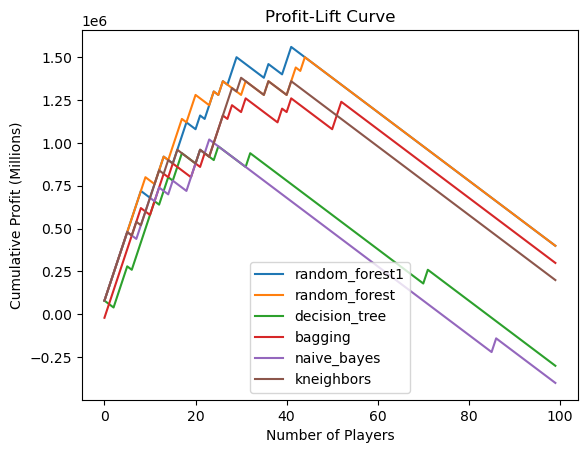

In [106]:
max_profits = {}

models = ['random_forest1', 'random_forest','decision_tree', 'bagging', 'naive_bayes', 'kneighbors']
for model in models:
    thresholds, profits = profit_curve(globals()[model], X_train, y_train, cost_matrix)
    max_profits[model] = max(profits)
    plt.plot(thresholds, profits)
    
plt.legend(['random_forest1', 'random_forest','decision_tree', 'bagging', 'naive_bayes', 'kneighbors'])
plt.xlabel('Number of Players')
plt.ylabel('Cumulative Profit (Millions)')
plt.title('Profit-Lift Curve')

max_model, max_profit = max(max_profits.items(), key=lambda x: x[1])
print(max_model, max_profit)

According to the profit lift curve, the best model will be the random forest model, because it yields the greatest maximum profit out of all the model at any number of players targeted.

**3.4: Using the model selected in 3.3, formulate clearly the investment strategy you will use to decide which players to invest in. The strategy should include the following:**

  **a. Which model to use (along with corresponding parameters, such as number and type of models in bagging ensemble, number of K nearest neighbors, etc.)**

  **b. Given your model’s estimated probability of induction, above what probability threshold to invest in a player’s memorabilia.**

  **(10 Points)**

In [111]:
def threshold_dict(mymodel):
    profit_dict = {}
    prob_pred = cross_val_predict(mymodel, X_train, y_train, cv = 10, method = 'predict_proba')

    positive_class_pred = []
    for pred in prob_pred:
        positive_class_pred.append(pred[1])

    prob_df = pd.DataFrame()
    prob_df['True'] = y_train
    prob_df['Prob']= positive_class_pred
    prob_df['TP'] = 0
    prob_df['FP'] = 0
    prob_df = prob_df.sort_values(by = 'Prob', ascending = False)

    for threshold in set(positive_class_pred):
        subset_df = prob_df[(prob_df['Prob'] >= threshold)]

        tp_count, fp_count = 0,0

        for index,row in subset_df.iterrows():
            if(row['True']) == True:
                tp_count += 1
            else:
                fp_count += 1

        profit = tp_count*80000 - fp_count*20000
        profit_dict[threshold] = profit
    
    max_profit_threshold = max(zip(profit_dict.values(), profit_dict.keys()))[1]
    return max_profit_threshold

In [119]:
threshold = threshold_dict(random_forest1)
print(f"Random Forest Model Optimal Threshold: {threshold*100:.2f} %")

Random Forest Model Optimal Threshold: 22.00 %


a. We used the random forest model to make our final proobability predictions. This was built with 100 estimators (aka bags, smaller decision trees), with a maximum of three features used in each tree.

b. Given our model estimated probability of induction, we should invest in a player's memorabilia if their predicted probability is above 22%. This is a sensible conclusion, since a true positive result is 4x as profitable as a false positive is costly. Therefore, at roughly a 20% threshold, we should become indifferent about whether or not to invest.

**3.5: Using `predict_proba`, predict probabilites for `class` with your best model on the testing data. Then, select which players to invest in based on the optimal probability threshold, display the list of players (along with their example number) in descending probability order, and report your profit. (10 Points)**

In [140]:
probabilities = random_forest1.predict_proba(X_test)
hof_probs = probabilities[:, 1]

NBA_Data = pd.read_csv('NBA_Data.csv',index_col=0)
X = NBA_Data.drop(columns=['class'])
y = NBA_Data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 3)

X_test['HOF Prob'] = hof_probs
X_test['class'] = y_test
X_test[X_test['HOF Prob'] > threshold].sort_values(by='HOF Prob', ascending=False)

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,lastSeason,careerEnded,yrsRetired2004,league_A,league_N,Position_C,Position_F,Position_G,HOF Prob,class
204,964.0,35875.0,14437.0,744.0,1827.0,14464.0,2575.0,125.0,553.0,0.0,...,1976.0,1.0,28.0,0,1,1,0,0,0.91,True
114,713.0,24897.0,16266.0,0.0,0.0,6129.0,1665.0,0.0,0.0,0.0,...,1961.0,1.0,43.0,0,1,0,1,0,0.91,True
353,963.0,40726.0,14522.0,0.0,0.0,21620.0,4100.0,0.0,0.0,0.0,...,1968.0,1.0,36.0,0,1,1,0,0,0.85,True
87,745.0,21731.0,13447.0,0.0,0.0,5116.0,2242.0,0.0,0.0,0.0,...,1969.0,1.0,35.0,0,1,0,1,0,0.80,True
73,1122.0,39788.0,21586.0,0.0,0.0,5665.0,4540.0,0.0,0.0,0.0,...,1972.0,1.0,32.0,0,1,0,0,1,0.79,True
80,825.0,30965.0,15581.0,403.0,1523.0,4830.0,5040.0,681.0,59.0,139.0,...,1979.0,1.0,25.0,0,1,0,0,1,0.78,True
14,1074.0,38113.0,26668.0,2950.0,4219.0,7169.0,2677.0,1378.0,642.0,2669.0,...,1998.0,1.0,6.0,0,1,0,1,0,0.77,True
228,1040.0,43886.0,26710.0,71.0,208.0,7804.0,9887.0,77.0,4.0,0.0,...,1973.0,1.0,31.0,0,1,0,0,1,0.70,True
397,1077.0,38064.0,17772.0,118.0,279.0,5030.0,7211.0,174.0,26.0,0.0,...,1974.0,1.0,30.0,0,1,0,0,1,0.68,True
287,876.0,31159.0,16481.0,344.0,1015.0,2046.0,6476.0,719.0,81.0,1123.0,...,1983.0,1.0,21.0,0,1,0,0,1,0.68,True


In [144]:
invested = X_test[X_test['HOF Prob'] > threshold]
tp = len(invested.loc[invested['class'] == True])
fp = len(invested.loc[invested['class'] == False])
profit = 80000*tp - 20000*fp
print('Profit: $'+ str(profit))

Profit: $1400000


## **OPTIONAL: Competition Deliverables and Guidelines**

To participate in the competition, the only modification your group should need to make is that instead of utilizing the split dataset approach requested in the homework (wherein your group split the data into training and testing sets), **your group should be working with the entire data set (495 records) when fitting and optimizing your model for profit!** This can take as little as 10 extra minutes, but we hope you'll surpass this minimum effort and invest time in developing a more effective and profitable model.

By choosing to participate (or failing to meet the regular deadline), your group will be given an extension on your HW4 submission. Additionally, the prizes are as follows (for each group member):

* **1st Place:** 20 Bonus points on the HW + Big Challah

* **2nd Place:** 15 Bonus points on the HW + Medium Challah

* **3rd Place:** 10 Bonus points on the HW + Bite-size Challah

Here are the deliverables your group must submit **in addition to the Homework assignment on Canvas:**

1. A new and separate Jupyter/Colab Notebook (.ipynb file) and title it
`cc[YourProfit_YourLastDayOnCampusThisSemester].ipynb`
  * For example, if your profit is $2,300,000 and the group member who is leaving campus the earliest is leaving on May 5th, call your file: `cc2300000_0505.ipynb`
  * This notebook should be able to recreate all of the steps necessary to generate your group's profit. This includes but is not limited to:
    * Feature selection/feature engineering steps,
    * the type of model your group selected,
    * the model parameters (i.e: number of bags, number of features in random forest, etc.),
    * the profit chart, and
    * the records selected by your group's model (as a pandas printout).

2. A CSV File of your group's final dataset after your group has performed any feature selection/engineering. **This is NOT the printout of records selected by your group's model. This is the dataset of the 495 records you have modified as-needed before fitting your group's model and reporting your group's profit.** If your group is unsure of how to export this file from Python to a CSV file, use the [to_csv()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html) method.

Additionally, here are some important guidelines to help your group with the competition:

1. As before, use 10-Fold Cross Validation on your group's model and report the accuracy and area under the ROC curve. **This is REQUIRED.**
2. If your group's total profit is less than 2 million, please go back to the drawing board.
  * Conversely, if your group's profit is greater than 3.4 million or more (approaches the maximum possible profit), also go back to the drawing board, as this likely means your group has made some mistake such as overfitting.
3. Your group is only being judged within the BAX section of this course. This means you are not competing with the other sections of this course listed as MIS/MKT and taught in WEKA.
4. When grading, we will only upload the original NBA_Data CSV file and then execute a 'run all' on your Jupyter/Colab notebook. Please ensure your group's notebook is optimized for this procedure (runs without errors or significant runtime) and is neat/organized. Failure to do so will result in an automatic disqualification from the competition.
5. Your group IS NOT limited to the five models we asked you to use for the homework assignment for this competition. Your group is more than welcome to use other techniques such as XGBoost or even a Neural Network! However, please keep in mind that these models will be more heavily scrutinized to check for mistakes and/or cheating.

If your group has any further questions about the competition or are unsure about something in the submission guidelines, please reach out to the Professor or TA as soon as possible! Good luck and happy (data) mining!